In [3]:
import pycine
import os
from contextlib import redirect_stdout
import cv2
import IPython
from pycine.color import color_pipeline, resize
from pycine.raw import read_frames, image_generator, frame_reader
from matplotlib import pyplot as plt
import numpy as np

def imshow(img):
    plt.figure()
    plt.imshow(img, 'gray')

def load_frame(cine_file, start_frame=1, count=1, is_color=False):
    with redirect_stdout(open(os.devnull, 'w')):
        raw_images, setup, bpp = read_frames(cine_file, start_frame=start_frame, count=count)
        raw_images = image_generator(cine_file, start_frame=start_frame, count=count)
        if is_color:
            ims = (color_pipeline(raw_image, setup=setup, bpp=bpp) for raw_image in raw_images)
        else:
            ims = raw_images

        for i, im in enumerate(ims):
            frame = start_frame + i
            if setup.EnableCrop:
                im = im[
                    setup.CropRect.top : setup.CropRect.bottom + 1, setup.CropRect.left : setup.CropRect.right + 1
                ]
            if setup.EnableResample:
                im = cv2.resize(im, (setup.ResampleWidth, setup.ResampleHeight))
            if im.dtype == np.float64:
                im = (im * 255).astype(np.uint8)
            if is_color:
                im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return im
def load_frames(file_path, st=1, end=1, dist=1, is_color=False):
    return np.array([load_frame(file_path, start_frame=f, count=1, is_color=is_color) for f in range(st, end, dist)])
file_path = r"C:\Users\PC_User\Desktop\pcc\#6_v2640.cine"

# img = load_frame(file_path, start_frame=500, count=1)
imgs = load_frames(file_path, st=1, end=900, dist=100, is_color=True)

# for img in imgs:
#     imshow(img)

c:\Users\PC_User\anaconda3\envs\pcc\lib\site-packages\pycine\color.py:142: RuntimeWarning: invalid value encountered in power
  rgb_image **= 1.0 / 2.2
C:\Users\PC_User\AppData\Local\Temp\ipykernel_20048\969556428.py:34: RuntimeWarning: invalid value encountered in cast
  im = (im * 255).astype(np.uint8)


C:\Users\PC_User\AppData\Local\Temp\ipykernel_20048\969556428.py:34: RuntimeWarning: invalid value encountered in cast
  im = (im * 255).astype(np.uint8)


12.478461283543123 m/s


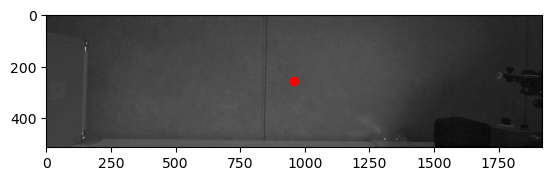

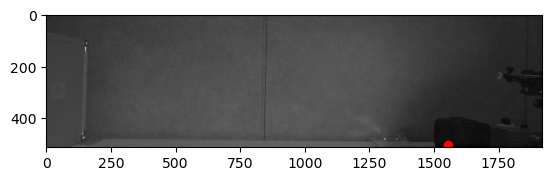

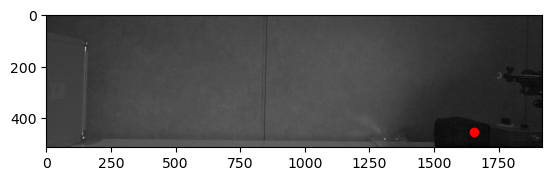

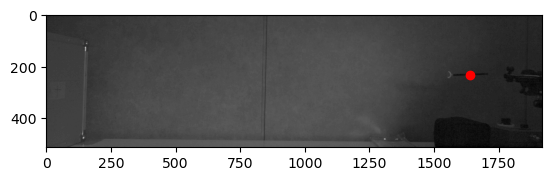

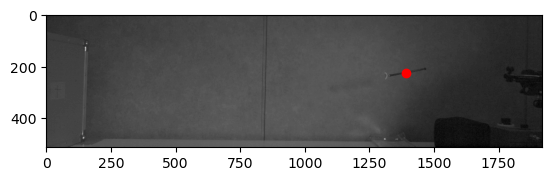

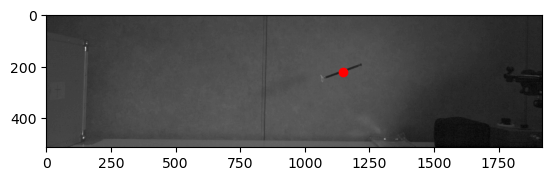

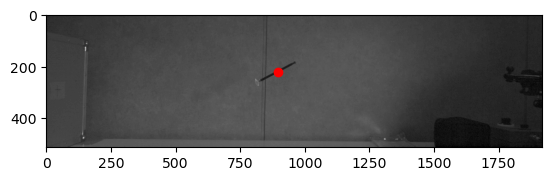

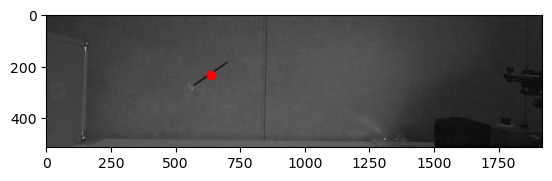

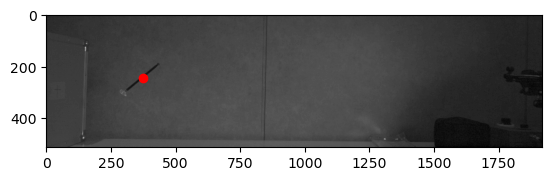

In [4]:
pix_per_m = 1000 #px/m
frame_rate = 5000 #frame/s
file_path = r"C:\Users\PC_User\Desktop\pcc\#6_v2640.cine"
dist = 100
imgs = load_frames(file_path, st=1, end=900, dist=dist, is_color=True)
# 背景差分器を初期化
fgbg = cv2.createBackgroundSubtractorMOG2()

# 重心を保存するリスト
centroids = []

for img in imgs:

    # 背景差分を適用
    fgmask = fgbg.apply(img)

    # 輪郭を検出
    contours, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # 最大の輪郭を取得（飛翔体を仮定）
        c = max(contours, key=cv2.contourArea)
        M = cv2.moments(c)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            centroids.append((cx, cy))
            # 重心をフレームに描画（視覚化のため）
            # cv2.circle(img, (cx, cy), 5, (0, 255, 0), -1)
        else:
            centroids.append((None, None))
    else:
        centroids.append((None, None))

    # フレームを表示
    imshow(img)
    plt.scatter(cx,cy, color='red')
centroids = np.array(centroids)
v = np.diff(centroids, axis=0)/dist #px/frame
v = v*(frame_rate/pix_per_m)
sp = np.linalg.norm(v, axis=1, ord=2)
sp_med = np.median(sp)
print(sp_med, 'm/s')

In [5]:
import pycine.file as cine_file
import numpy as np
import cv2

# .cine ファイルのパスを指定
# file_path = '/mnt/data/pcc.ipynb'

# ヘッダー情報を取得
header = cine_file.read_header(file_path)

# フレームレートを取得
frame_rate = header['setup'].FrameRate
print('frame rate',frame_rate)

# メタデータを表示
print('#######################')
print("CINEFILEHEADER:")
print('#######################')
for key, value in header['cinefileheader']._fields_:
    print(f"{key}: {getattr(header['cinefileheader'], key)}")

print('#######################')
print("\nBITMAPINFOHEADER:")
print('#######################')
for key, value in header['bitmapinfoheader']._fields_:
    print(f"{key}: {getattr(header['bitmapinfoheader'], key)}")

print('#######################')
print("\nSETUP:")
print('#######################')
for key, value in header['setup']._fields_:
    print(f"{key}: {getattr(header['setup'], key)}")

print('#######################')
print("\nその他のメタデータ:")
print(f"pImage: {header['pImage'][:10]}")  # 最初の10個のフレームオフセットを表示
# print(f"timestamp: {header['timestamp'][:10]}")  # 最初の10個のタイムスタンプを表示
# print(f"exposuretime: {header['exposuretime'][:10]}")  # 最初の10個の露光時間を表示



frame rate 5000
#######################
CINEFILEHEADER:
#######################
Type: 18755
Headersize: 44
Compression: 2
Version: 1
FirstMovieImage: -33288
TotalImageCount: 36289
FirstImageNo: -4865
ImageCount: 897
OffImageHeader: 44
OffSetup: 84
OffImageOffsets: 28732
TriggerTime: <pycine.cine.tagTIME64 object at 0x0000017966B886C0>
#######################

BITMAPINFOHEADER:
#######################
biSize: 40
biWidth: 1920
biHeight: 512
biPlanes: 1
biBitCount: 16
biCompression: 256
biSizeImage: 1228800
biXPelsPerMeter: 74074
biYPelsPerMeter: 74074
biClrUsed: 0
biClrImportant: 1024
#######################

SETUP:
#######################
FrameRate16: 5000
Shutter16: 99
PostTrigger16: 3001
FrameDelay16: 0
AspectRatio: 1
Res7: 0
Res8: 0
Res9: 0
Res10: 0
Res11: 0
TrigFrame: 1
Res12: 0
DescriptionOld: b''
Mark: 21587
Length: 10684
Res13: 0
SigOption: 0
BinChannels: 0
SamplesPerImage: 1
BinName: <pycine.cine.c_char_Array_11_Array_8 object at 0x0000017966B88740>
AnaOption: 0
AnaChannels: 0
R

In [160]:
# メタデータを表示
print("#######################")
print("CINEFILEHEADER:")
print("#######################")
print(f"FirstMovieImage: {header['cinefileheader'].FirstMovieImage}")
print(f"TotalImageCount: {header['cinefileheader'].TotalImageCount}")
print(f"FirstImageNo: {header['cinefileheader'].FirstImageNo}")
print(f"ImageCount: {header['cinefileheader'].ImageCount}")

# 切り取られたフレームの範囲を計算
first_image_no = header['cinefileheader'].FirstImageNo
image_count = header['cinefileheader'].ImageCount
last_image_no = first_image_no + image_count - 1

print(f"First Image No: {first_image_no}")
print(f"Last Image No: {last_image_no}")
print(f"Total Frames in the Range: {image_count}")
print("#######################")

frame_rate = header['setup'].FrameRate16
shutter_speed = header['setup'].Shutter16
image_width = header['bitmapinfoheader'].biWidth
image_height = header['bitmapinfoheader'].biHeight

print("#######################")
print("Cine File Metadata")
print("#######################")
print(f"Frame Rate: {frame_rate} fps")
print(f"Shutter Speed: {shutter_speed}")
print(f"Image Width: {image_width} pixels")
print(f"Image Height: {image_height} pixels")
print("#######################")

#######################
CINEFILEHEADER:
#######################
FirstMovieImage: -33288
TotalImageCount: 36289
FirstImageNo: -4865
ImageCount: 897
First Image No: -4865
Last Image No: -3969
Total Frames in the Range: 897
#######################
#######################
Cine File Metadata
#######################
Frame Rate: 5000 fps
Shutter Speed: 99
Image Width: 1920 pixels
Image Height: 512 pixels
#######################


nan m/s


c:\Users\PC_User\anaconda3\envs\pcc\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\PC_User\anaconda3\envs\pcc\lib\site-packages\numpy\core\_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


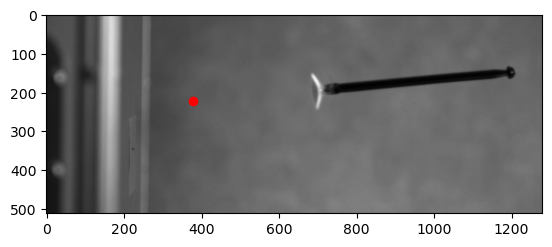

In [20]:
start_frame = 1
count=1
cine_file = r"C:\Users\PC_User\Desktop\pcc\#1_710_1.cine"
raw_images, setup, bpp = read_frames(cine_file, start_frame=start_frame, count=count)
raw_images = image_generator(cine_file, start_frame=start_frame, count=count)
centroids=[]
for img in raw_images:

    # 背景差分を適用
    fgmask = fgbg.apply(img)

    # 輪郭を検出
    contours, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # 最大の輪郭を取得（飛翔体を仮定）
        c = max(contours, key=cv2.contourArea)
        M = cv2.moments(c)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroids.append((cx, cy))
            # 重心をフレームに描画（視覚化のため）
            # cv2.circle(img, (cx, cy), 5, (0, 255, 0), -1)
        else:
            centroids.append((None, None))
    else:
        centroids.append((None, None))

    # フレームを表示
    imshow(img)
    plt.scatter(cx, cy, color="red")
centroids = np.array(centroids)
v = np.diff(centroids, axis=0) / dist  # px/frame
v = v * (frame_rate / pix_per_m)
sp = np.linalg.norm(v, axis=1, ord=2)
sp_med = np.median(sp)
print(sp_med, "m/s")

In [13]:
# ヘッダー情報を取得
header = cine_file.read_header(file_path)

# カラー画像かどうか
is_color = header["setup"].bEnableColor
print(is_color)

0
